In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Étape 1 : Chargement du dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation des features ---
# Cible
y = df['status_label']

# Features : exclure company_name, status_label et les colonnes déjà mappées si on ne veut pas fuites
features = df.drop(columns=['company_name', 'status_label'])

# Encodage des colonnes catégorielles
categorical_cols = features.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))

# --- Étape 3 : Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42, stratify=y
)

# --- Étape 4 : Random Forest baseline ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # important si classes déséquilibrées
)
rf.fit(X_train, y_train)

# --- Étape 5 : Évaluation ---
y_pred = rf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Étape 6 : Feature importance (optionnel) ---
importances = pd.Series(rf.feature_importances_, index=features.columns)
importances = importances.sort_values(ascending=False)
print("\nTop 10 features importantes :")
print(importances.head(10))


Accuracy : 0.97

Confusion Matrix:
 [[ 1  3]
 [ 0 96]]

Classification Report:
               precision    recall  f1-score   support

       alive       1.00      0.25      0.40         4
      failed       0.97      1.00      0.98        96

    accuracy                           0.97       100
   macro avg       0.98      0.62      0.69       100
weighted avg       0.97      0.97      0.96       100


Top 10 features importantes :
ebit                             0.223856
total_long_term_debts            0.113946
net_sales                        0.085005
retained_earnings                0.076005
net_income                       0.073836
total_receivables                0.066468
total_revenue                    0.045054
total_assets                     0.034869
depreciation_and_amortization    0.029130
costs_of_good_sold               0.028781
dtype: float64


Accuracy : 0.96
ROC AUC : 0.6458333333333333

Confusion Matrix:
 [[ 1  3]
 [ 1 95]]

Classification Report:
               precision    recall  f1-score   support

       alive       0.50      0.25      0.33         4
      failed       0.97      0.99      0.98        96

    accuracy                           0.96       100
   macro avg       0.73      0.62      0.66       100
weighted avg       0.95      0.96      0.95       100


Top 10 features importantes :
ebit                             0.240636
total_long_term_debts            0.121044
net_sales                        0.097136
net_income                       0.083392
retained_earnings                0.078243
total_receivables                0.067871
total_revenue                    0.035558
total_assets                     0.032893
depreciation_and_amortization    0.028000
market_value                     0.025574
dtype: float64


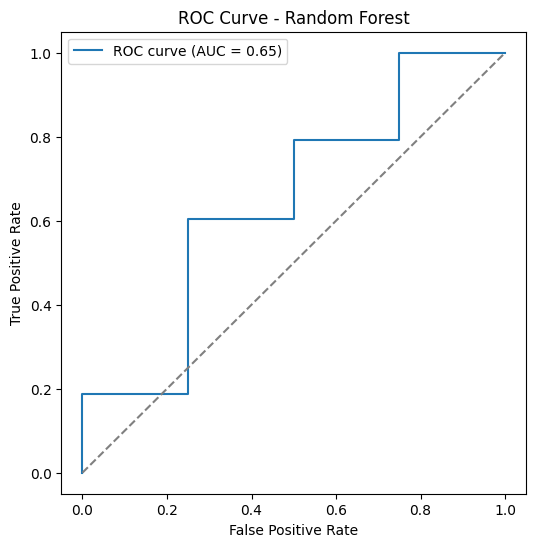

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- Étape 1 : Chargement du dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation des features ---
y = df['status_label']
X = df.drop(columns=['company_name', 'status_label'])

# Encodage des colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# --- Étape 3 : Split train/test stratifié ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Étape 4 : Random Forest optimisé ---
rf = RandomForestClassifier(
    n_estimators=300,         # plus d’arbres pour stabilité
    max_depth=None,           # profondeur illimitée
    min_samples_leaf=10,      # éviter overfitting
    class_weight='balanced',  # gérer le déséquilibre
    random_state=42,
    n_jobs=-1                 # utiliser tous les cores dispo
)

rf.fit(X_train, y_train)

# --- Étape 5 : Prédictions ---
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]  # probabilité pour ROC

# --- Étape 6 : Évaluation ---
print("Accuracy :", accuracy_score(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Étape 7 : Feature importance ---
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print("\nTop 10 features importantes :")
print(importances.head(10))

# --- Étape 8 : Courbe ROC ---
fpr, tpr, thresholds = roc_curve(y_test.map({'alive':0,'failed':1}), y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


Seuil optimal pour F1-score (failed) : 0.1

Classification Report :
               precision    recall  f1-score   support

       alive       1.00      0.25      0.40         4
      failed       0.97      1.00      0.98        96

    accuracy                           0.97       100
   macro avg       0.98      0.62      0.69       100
weighted avg       0.97      0.97      0.96       100

Confusion Matrix :
 [[ 1  3]
 [ 0 96]]
ROC AUC : 0.6484375

Top 10 features importantes :
ebit                             0.237764
retained_earnings                0.149580
net_sales                        0.100868
total_long_term_debts            0.098122
net_income                       0.079771
total_receivables                0.056508
market_value                     0.039256
costs_of_good_sold               0.033778
depreciation_and_amortization    0.027720
total_revenue                    0.027572
dtype: float64


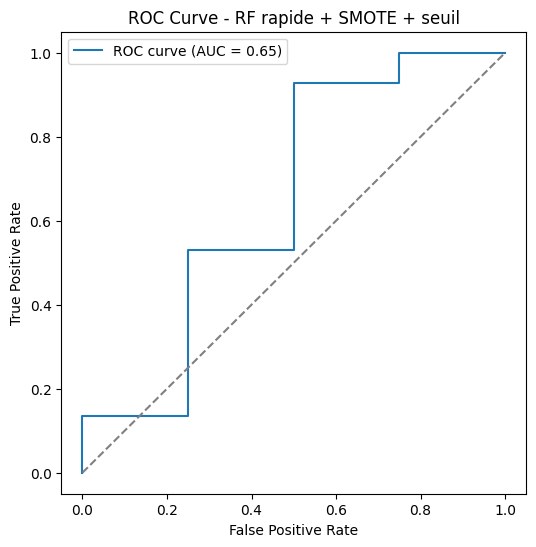

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# --- Étape 1 : Chargement dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation features ---
y = df['status_label']
X = df.drop(columns=['company_name','status_label'])

categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# --- Étape 3 : Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Étape 4 : SMOTE pour déséquilibre ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Étape 5 : Random Forest rapide ---
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

# --- Étape 6 : Prédictions et probabilités ---
y_proba = rf.predict_proba(X_test)[:,1]

# --- Étape 7 : Ajustement seuil pour F1-score failed ---
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
for t in thresholds:
    y_pred_thresh = np.where(y_proba > t, 'failed', 'alive')
    f1_scores.append(f1_score(y_test.map({'alive':0,'failed':1}),
                               pd.Series(y_pred_thresh).map({'alive':0,'failed':1})))
best_thresh = thresholds[np.argmax(f1_scores)]
print("Seuil optimal pour F1-score (failed) :", best_thresh)

# Predictions avec le seuil optimal
y_pred = np.where(y_proba > best_thresh, 'failed', 'alive')

# --- Étape 8 : Évaluation finale ---
print("\nClassification Report :\n", classification_report(y_test, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba))

# --- Étape 9 : Feature importance ---
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features importantes :")
print(importances.head(10))

# --- Étape 10 : Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test.map({'alive':0,'failed':1}), y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba):.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RF rapide + SMOTE + seuil")
plt.legend()
plt.show()

In [14]:
import lightgbm as lgb
print("LightGBM version :", lgb.__version__)
print("LGBMClassifier existe :", hasattr(lgb, 'LGBMClassifier'))

LightGBM version : 4.6.0
LGBMClassifier existe : True


In [15]:
lgbm = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=64,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Utiliser callbacks pour early stopping
lgbm.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(50)]  # affiche le log tous les 50 itérations
)


[LightGBM] [Info] Number of positive: 385, number of negative: 385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4670
[LightGBM] [Info] Number of data points in the train set: 770, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


[LightGBM] [Info] Number of positive: 385, number of negative: 385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4670
[LightGBM] [Info] Number of data points in the train set: 770, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

C:\Users\Thomas L\.venv311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Thomas L\.venv311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Thomas L\.venv311\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


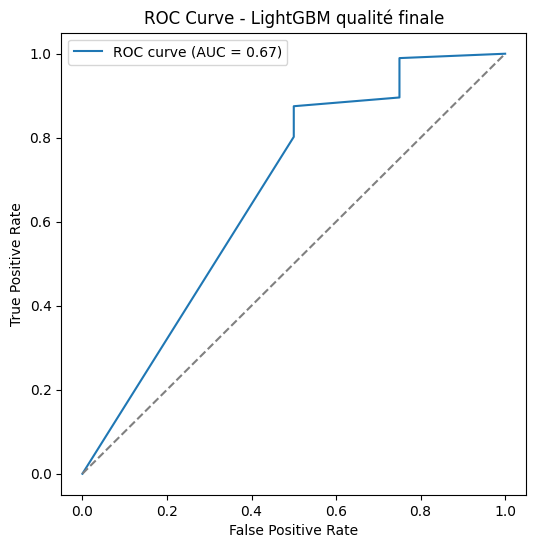

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt

# --- Étape 1 : Chargement dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation features ---
y = df['status_label']
X = df.drop(columns=['company_name','status_label'])

# Encodage des colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# --- Étape 3 : Split train/test stratifié ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Étape 4 : SMOTE pour déséquilibre ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Étape 5 : LightGBM qualité finale ---
lgbm = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=64,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Early stopping via callbacks
lgbm.fit(
    X_train_res, y_train_res,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)  # affiche log tous les 50 itérations
    ]
)

# --- Étape 6 : Probabilités et seuil optimisé ---
y_proba = lgbm.predict_proba(X_test)[:,1]

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_thresh = np.where(y_proba > t, 'failed', 'alive')
    f1_scores.append(f1_score(y_test.map({'alive':0,'failed':1}),
                               pd.Series(y_pred_thresh).map({'alive':0,'failed':1})))
best_thresh = thresholds[np.argmax(f1_scores)]
print("Seuil optimal pour F1-score (failed) :", best_thresh)

y_pred = np.where(y_proba > best_thresh, 'failed', 'alive')

# --- Étape 7 : Évaluation finale ---
print("\nClassification Report :\n", classification_report(y_test, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba))

# --- Étape 8 : Feature importance ---
importances = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features importantes :")
print(importances.head(10))

# --- Étape 9 : Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test.map({'alive':0,'failed':1}), y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba):.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM qualité finale")
plt.legend()
plt.show()


In [17]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


[0]	train-auc:0.98494	eval-auc:0.67057
[50]	train-auc:0.99979	eval-auc:0.74479
[100]	train-auc:0.99990	eval-auc:0.75781
[150]	train-auc:0.99994	eval-auc:0.74219
Seuil optimal pour F1-score (failed) : 0.12

Classification Report :
               precision    recall  f1-score   support

       alive       1.00      0.25      0.40         4
      failed       0.97      1.00      0.98        96

    accuracy                           0.97       100
   macro avg       0.98      0.62      0.69       100
weighted avg       0.97      0.97      0.96       100

Confusion Matrix :
 [[ 1  3]
 [ 0 96]]
ROC AUC : 0.7421875

Top 10 features importantes :
ebit                             166.0
depreciation_and_amortization    162.0
net_sales                        146.0
retained_earnings                146.0
total_revenue                    130.0
majorgroup_name                   92.0
inventory                         76.0
total_long_term_debts             69.0
total_assets                      67.0
m

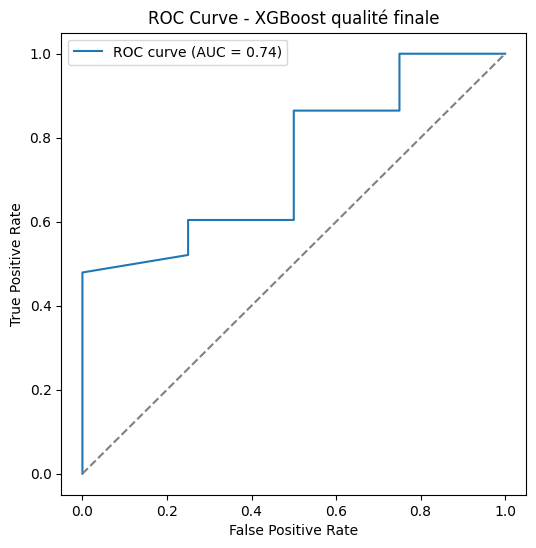

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# --- Étape 1 : Chargement dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation features ---
y = df['status_label']
X = df.drop(columns=['company_name','status_label'])

# Encodage des colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# --- Étape 3 : Split train/test stratifié ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Étape 4 : SMOTE pour déséquilibre ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Étape 5 : Conversion DMatrix pour XGBoost ---
dtrain = xgb.DMatrix(X_train_res, label=y_train_res.map({'alive':0,'failed':1}))
dtest  = xgb.DMatrix(X_test, label=y_test.map({'alive':0,'failed':1}))

# --- Étape 6 : Paramètres XGBoost ---
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'auc',
    'scale_pos_weight': len(y_train_res[y_train_res=='alive']) / len(y_train_res[y_train_res=='failed']),
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# --- Étape 7 : Entraînement avec early stopping ---
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=50
)

# --- Étape 8 : Probabilités et seuil optimisé ---
y_proba = xgb_model.predict(dtest)

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_thresh = np.where(y_proba > t, 'failed', 'alive')
    f1_scores.append(f1_score(y_test.map({'alive':0,'failed':1}),
                               pd.Series(y_pred_thresh).map({'alive':0,'failed':1})))
best_thresh = thresholds[np.argmax(f1_scores)]
print("Seuil optimal pour F1-score (failed) :", best_thresh)

y_pred = np.where(y_proba > best_thresh, 'failed', 'alive')

# --- Étape 9 : Évaluation finale ---
print("\nClassification Report :\n", classification_report(y_test, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba))

# --- Étape 10 : Feature importance ---
importances = pd.Series(xgb_model.get_score(importance_type='weight'))
importances.index = [col if col in X.columns else f"f{col}" for col in importances.index]
importances = importances.sort_values(ascending=False)
print("\nTop 10 features importantes :")
print(importances.head(10))

# --- Étape 11 : Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test.map({'alive':0,'failed':1}), y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba):.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost qualité finale")
plt.legend()
plt.show()


Seuil optimal: 0.12

DÉBUT ANALYSE SHAP

Calcul des valeurs SHAP en cours...
✓ Valeurs SHAP calculées

1. Création du Summary Plot...


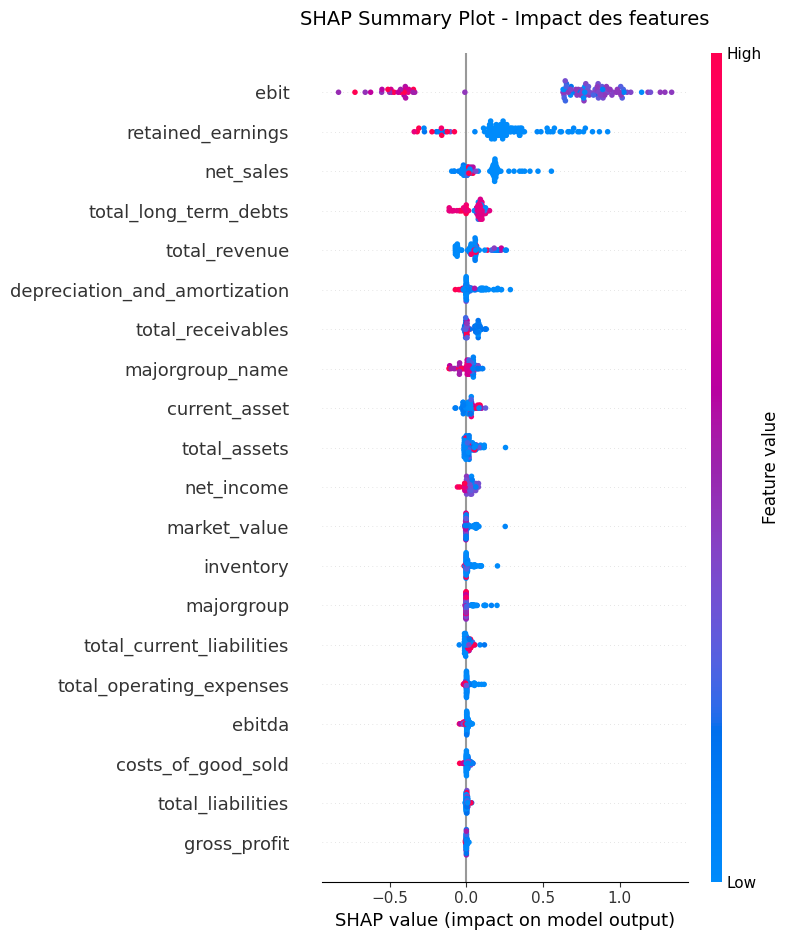

2. Création du Bar Plot...


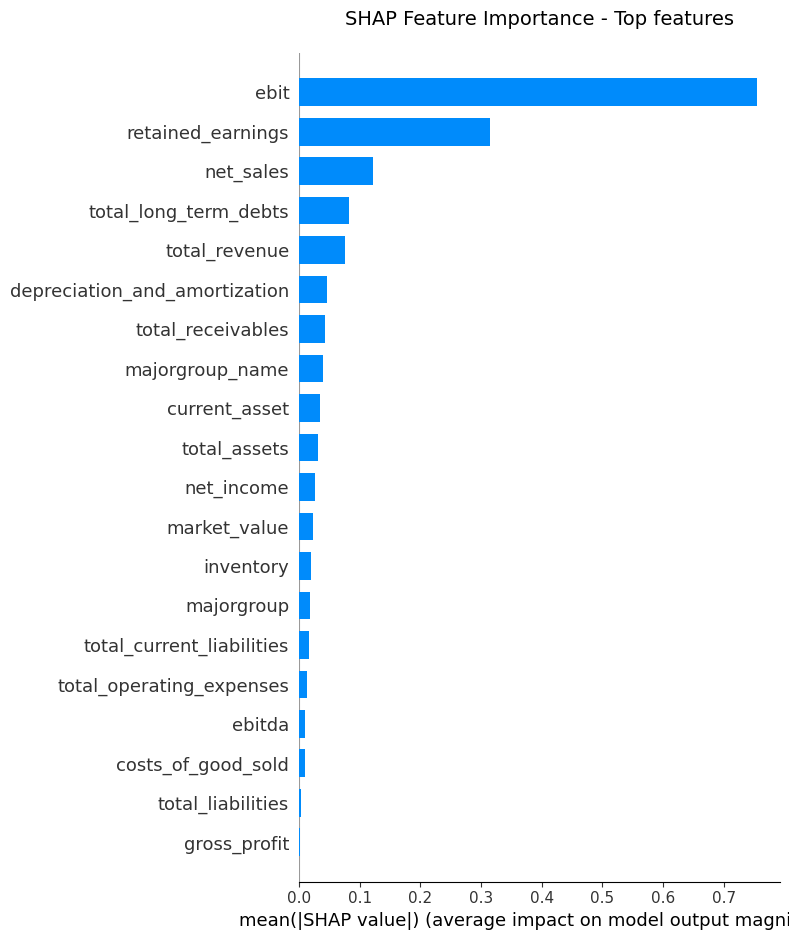

3. Waterfall Plot pour une prédiction...


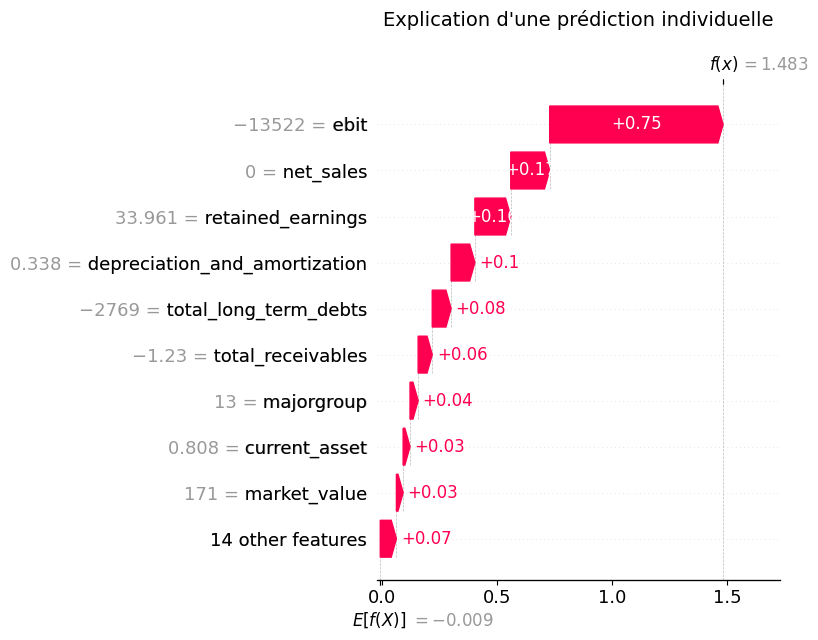

4. Dependence Plots pour features clés...


<Figure size 1000x600 with 0 Axes>

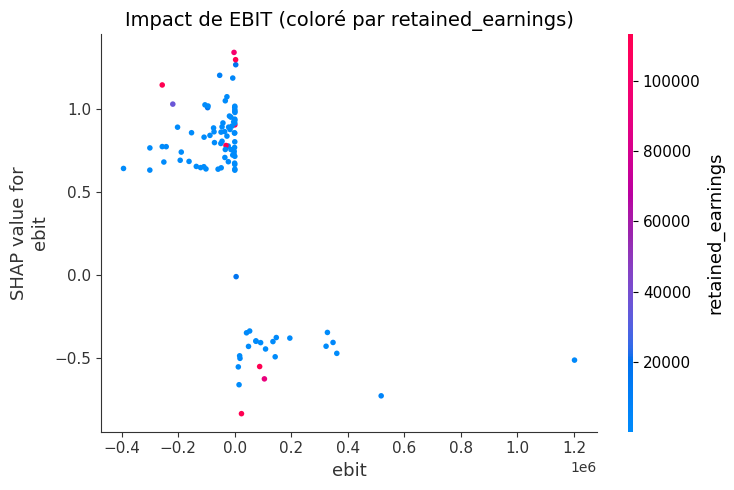

<Figure size 1000x600 with 0 Axes>

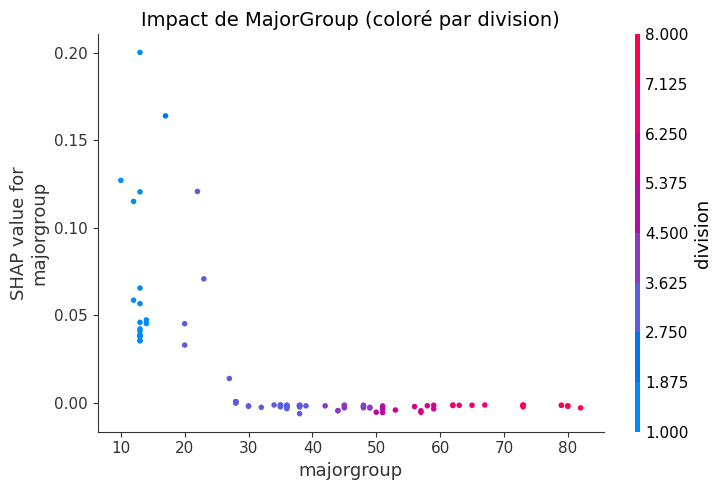


5. Analyse comparative Failed vs Alive...

📊 Top 10 features pour FAILED:
                      feature  mean_abs_shap
                         ebit       0.745062
            retained_earnings       0.318531
                    net_sales       0.121859
        total_long_term_debts       0.081133
                total_revenue       0.077635
depreciation_and_amortization       0.047305
            total_receivables       0.043685
              majorgroup_name       0.038842
                current_asset       0.035411
                 total_assets       0.032679

📊 Top 10 features pour ALIVE:
              feature  mean_abs_shap
                 ebit       0.990864
    retained_earnings       0.231198
            net_sales       0.130509
total_long_term_debts       0.112567
      majorgroup_name       0.067085
        total_revenue       0.051013
    total_receivables       0.026646
           net_income       0.018046
         total_assets       0.017353
        current_asset       0

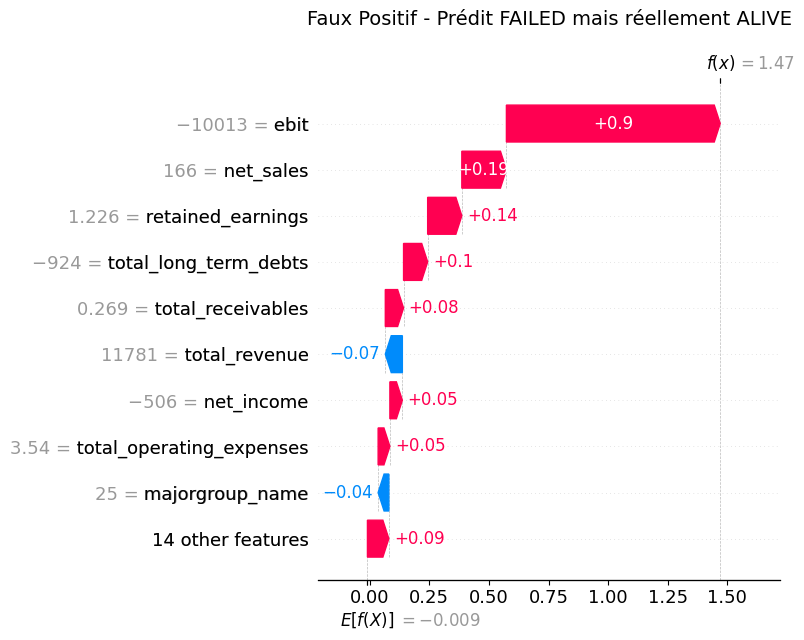


✅ ANALYSE SHAP TERMINÉE


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# ============================================
# PARTIE 1: PRÉPARATION DES DONNÉES (déjà fait)
# ============================================
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

y = df['status_label']
X = df.drop(columns=['company_name','status_label'])

categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ============================================
# PARTIE 2: ENTRAÎNEMENT XGBOOST (déjà fait)
# ============================================
dtrain = xgb.DMatrix(X_train_res, label=y_train_res.map({'alive':0,'failed':1}))
dtest = xgb.DMatrix(X_test, label=y_test.map({'alive':0,'failed':1}))

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'auc',
    'scale_pos_weight': len(y_train_res[y_train_res=='alive']) / len(y_train_res[y_train_res=='failed']),
    'seed': 42
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Trouver le seuil optimal (déjà calculé: 0.43)
y_proba = xgb_model.predict(dtest)
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_thresh = np.where(y_proba > t, 'failed', 'alive')
    f1_scores.append(f1_score(y_test.map({'alive':0,'failed':1}),
                               pd.Series(y_pred_thresh).map({'alive':0,'failed':1})))
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Seuil optimal: {best_thresh:.2f}")

# ============================================
# PARTIE 3: ANALYSE SHAP
# ============================================
print("\n" + "="*60)
print("DÉBUT ANALYSE SHAP")
print("="*60)

# Créer l'explainer SHAP
explainer = shap.TreeExplainer(xgb_model)

# Calculer les valeurs SHAP (peut prendre quelques minutes)
print("\nCalcul des valeurs SHAP en cours...")
shap_values = explainer.shap_values(X_test)
print("✓ Valeurs SHAP calculées")

# ============================================
# 1. SUMMARY PLOT - Vue d'ensemble
# ============================================
print("\n1. Création du Summary Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Impact des features", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# ============================================
# 2. BAR PLOT - Importance moyenne
# ============================================
print("2. Création du Bar Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Top features", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# ============================================
# 3. WATERFALL - Explication individuelle
# ============================================
print("3. Waterfall Plot pour une prédiction...")
shap_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[0].values,
    feature_names=X_test.columns.tolist()
)

plt.figure(figsize=(12, 6))
shap.waterfall_plot(shap_explanation, show=False)
plt.title("Explication d'une prédiction individuelle", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# ============================================
# 4. DEPENDENCE PLOT - Relations
# ============================================
print("4. Dependence Plots pour features clés...")

# EBIT
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "ebit",
    shap_values,
    X_test,
    interaction_index="retained_earnings",
    show=False
)
plt.title("Impact de EBIT (coloré par retained_earnings)", fontsize=14)
plt.tight_layout()
plt.show()

# MajorGroup
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "majorgroup",
    shap_values,
    X_test,
    interaction_index="division",
    show=False
)
plt.title("Impact de MajorGroup (coloré par division)", fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# 5. ANALYSE FAILED vs ALIVE
# ============================================
print("\n5. Analyse comparative Failed vs Alive...")

failed_idx = np.where(y_test == 'failed')[0]
alive_idx = np.where(y_test == 'alive')[0]

failed_shap_mean = np.abs(shap_values[failed_idx]).mean(axis=0)
alive_shap_mean = np.abs(shap_values[alive_idx]).mean(axis=0)

top_failed = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': failed_shap_mean
}).sort_values('mean_abs_shap', ascending=False).head(10)

top_alive = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': alive_shap_mean
}).sort_values('mean_abs_shap', ascending=False).head(10)

print("\n📊 Top 10 features pour FAILED:")
print(top_failed.to_string(index=False))

print("\n📊 Top 10 features pour ALIVE:")
print(top_alive.to_string(index=False))

# ============================================
# 6. ANALYSE DES ERREURS
# ============================================
print("\n6. Analyse des faux positifs/négatifs...")

y_pred_binary = (y_proba > best_thresh).astype(int)
y_pred = np.where(y_pred_binary == 1, 'failed', 'alive')

false_positives = np.where((y_pred == 'failed') & (y_test == 'alive'))[0]
false_negatives = np.where((y_pred == 'alive') & (y_test == 'failed'))[0]

print(f"\n❌ Nombre de faux positifs: {len(false_positives)}")
print(f"❌ Nombre de faux négatifs: {len(false_negatives)}")

# Analyser un faux positif
if len(false_positives) > 0:
    fp_idx = false_positives[0]
    print(f"\n🔍 Analyse FAUX POSITIF (index {fp_idx}):")
    print(f"   Prédit: FAILED | Réalité: ALIVE")
    print(f"   Probabilité: {y_proba[fp_idx]:.3f}")
    
    shap_explanation_fp = shap.Explanation(
        values=shap_values[fp_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[fp_idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_explanation_fp, show=False)
    plt.title(f"Faux Positif - Prédit FAILED mais réellement ALIVE", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Analyser un faux négatif
if len(false_negatives) > 0:
    fn_idx = false_negatives[0]
    print(f"\n🔍 Analyse FAUX NÉGATIF (index {fn_idx}):")
    print(f"   Prédit: ALIVE | Réalité: FAILED")
    print(f"   Probabilité: {y_proba[fn_idx]:.3f}")
    
    shap_explanation_fn = shap.Explanation(
        values=shap_values[fn_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[fn_idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_explanation_fn, show=False)
    plt.title(f"Faux Négatif - Prédit ALIVE mais réellement FAILED", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("✅ ANALYSE SHAP TERMINÉE")
print("="*60)

Colonnes avant nettoyage: 23
Colonnes après nettoyage: 21

Colonnes conservées:
['fyear', 'current_asset', 'costs_of_good_sold', 'depreciation_and_amortization', 'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value', 'net_sales', 'total_assets', 'total_long_term_debts', 'ebit', 'gross_profit', 'total_current_liabilities', 'retained_earnings', 'total_revenue', 'total_liabilities', 'total_operating_expenses', 'division_name', 'majorgroup_name']

Colonnes catégorielles à encoder: ['division_name', 'majorgroup_name']

📋 Mapping division_name:
  Agriculture, Forestry & Fishing -> 0
  Construction -> 1
  Finance, Insurance & Real Estate -> 2
  Manufacturing -> 3
  Mining -> 4
  ... (9 catégories au total)

📋 Mapping majorgroup_name:
  Agricultural Production – Crops -> 0
  Air Transportation -> 1
  Amusement & Recreation -> 2
  Apparel & Finished Products -> 3
  Apparel Stores -> 4
  ... (48 catégories au total)

ENTRAÎNEMENT XGBOOST
[0]	train-auc:0.98956	eval-auc:0.66667


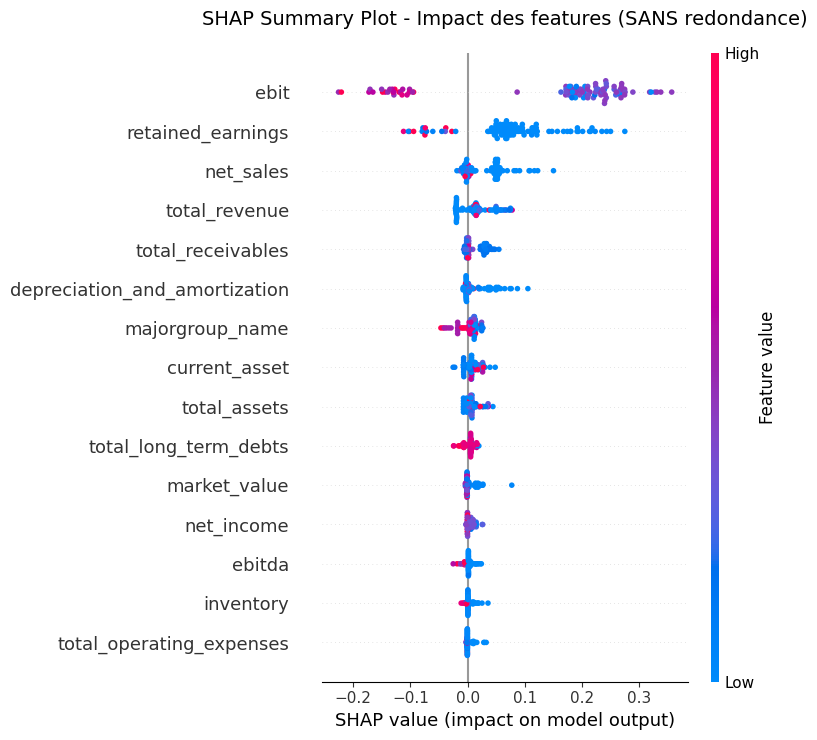

2. Bar Plot...


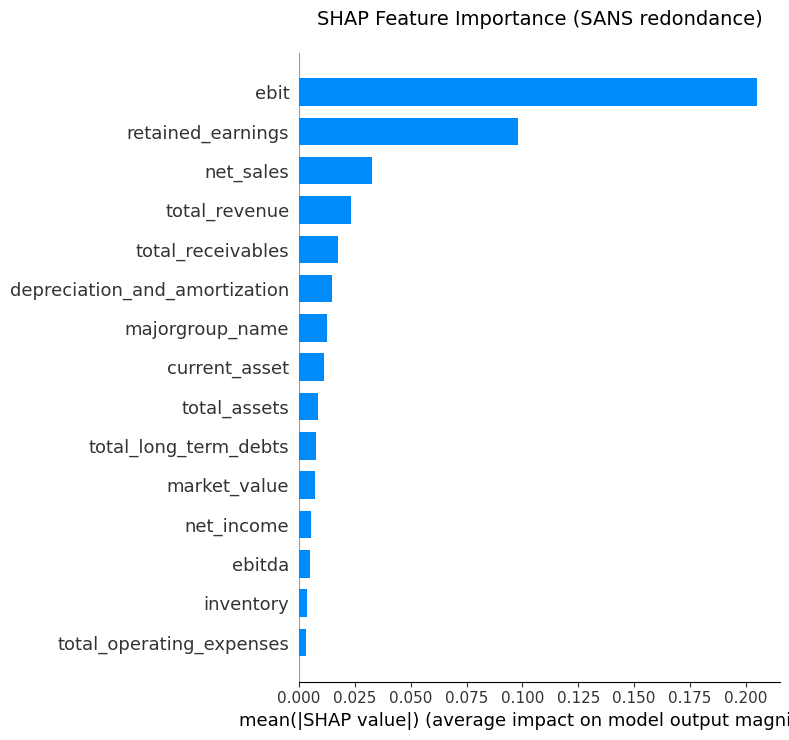


3. Comparaison Feature Importance...

📊 Comparaison XGBoost vs SHAP (Top 15):
                      feature  shap_importance  xgb_importance
                         ebit         0.205091            87.0
            retained_earnings         0.097863            61.0
                    net_sales         0.032875            79.0
                total_revenue         0.023368            67.0
            total_receivables         0.017279            26.0
depreciation_and_amortization         0.014987            87.0
              majorgroup_name         0.012599            45.0
                current_asset         0.011367            29.0
                 total_assets         0.008642            32.0
        total_long_term_debts         0.007757            32.0
                 market_value         0.007139            29.0
                   net_income         0.005221            29.0
                       ebitda         0.005026            17.0
                    inventory         0

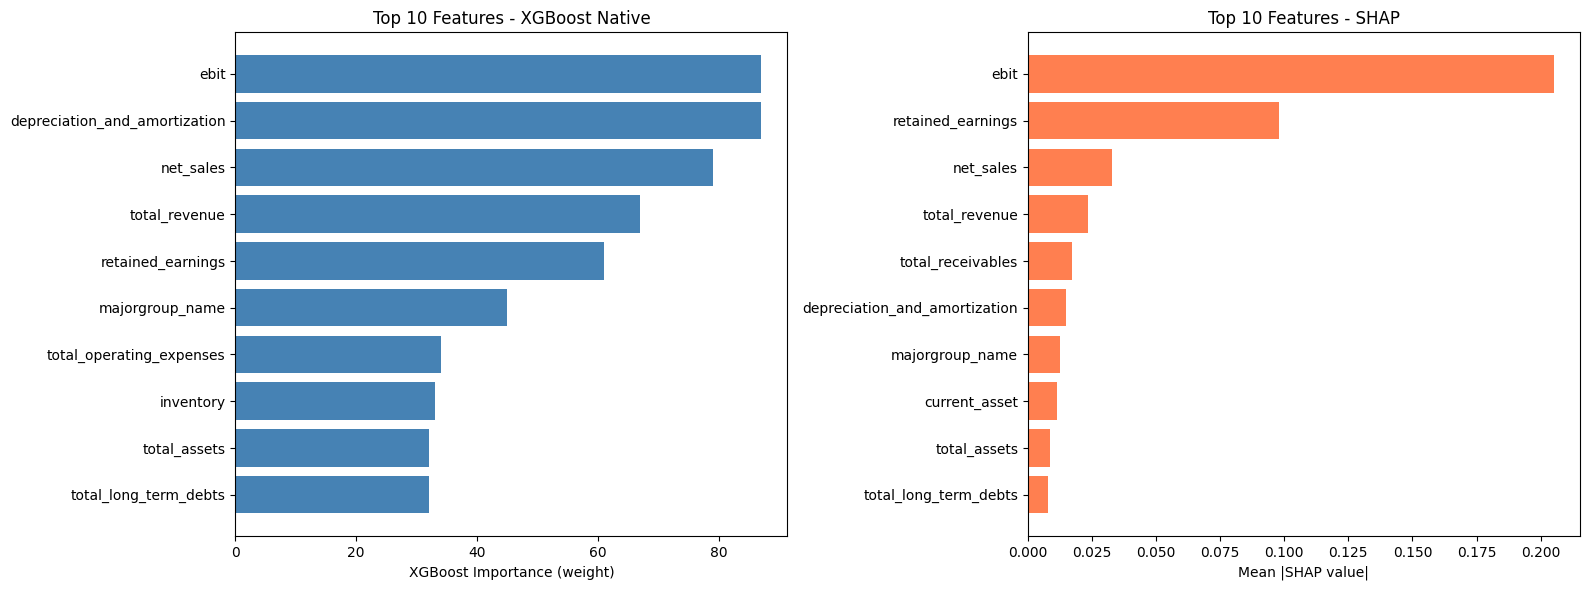


4. Dependence Plots...


<Figure size 1000x600 with 0 Axes>

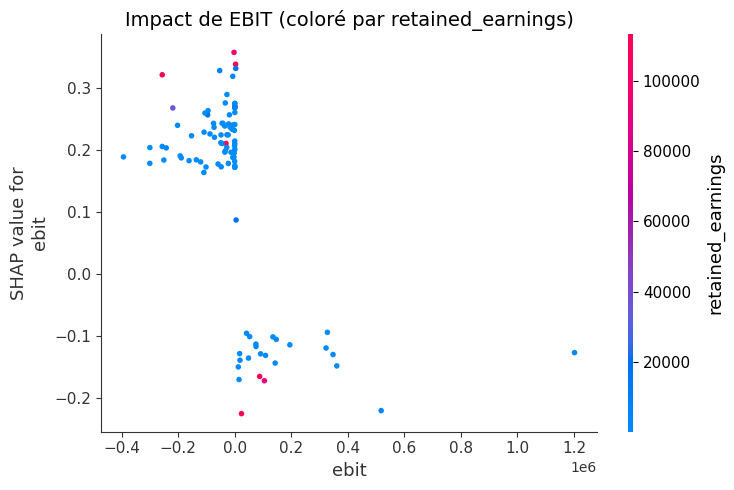

<Figure size 1000x600 with 0 Axes>

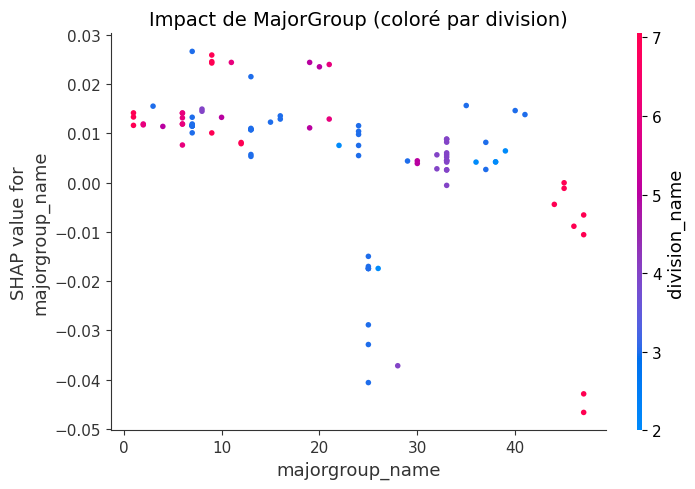


5. Analyse comparative Failed vs Alive...

💥 Top 10 features pour FAILED:
                      feature  mean_abs_shap_failed
                         ebit              0.202564
            retained_earnings              0.098956
                    net_sales              0.032803
                total_revenue              0.023789
            total_receivables              0.017529
depreciation_and_amortization              0.015382
              majorgroup_name              0.012000
                current_asset              0.011623
                 total_assets              0.008828
        total_long_term_debts              0.007567

✅ Top 10 features pour ALIVE:
                      feature  mean_abs_shap_alive
                         ebit             0.265750
            retained_earnings             0.071639
                    net_sales             0.034605
              majorgroup_name             0.026983
                total_revenue             0.013276
        total_lo

C:\Users\Thomas L\AppData\Local\Temp\ipykernel_14640\1117117074.py:267: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Thomas L\.venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


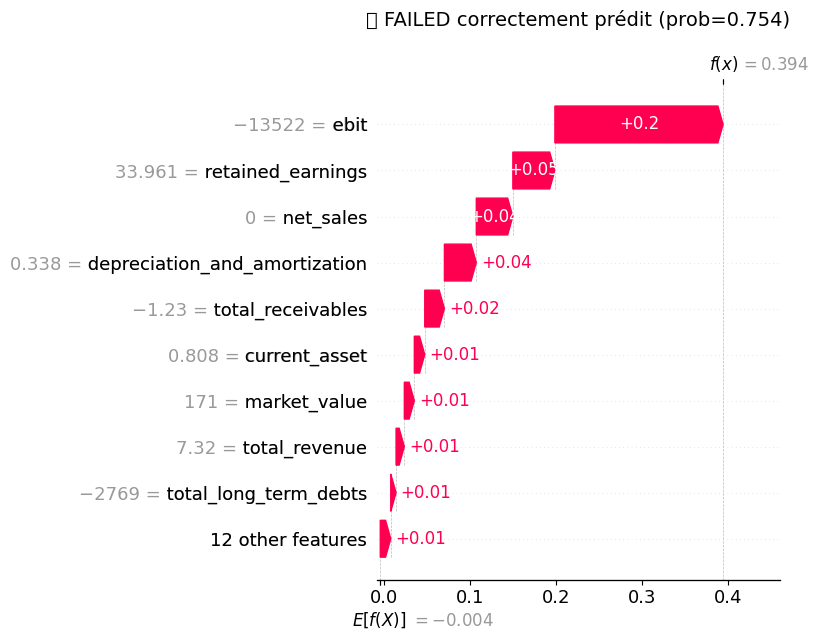

C:\Users\Thomas L\AppData\Local\Temp\ipykernel_14640\1117117074.py:284: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Thomas L\.venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


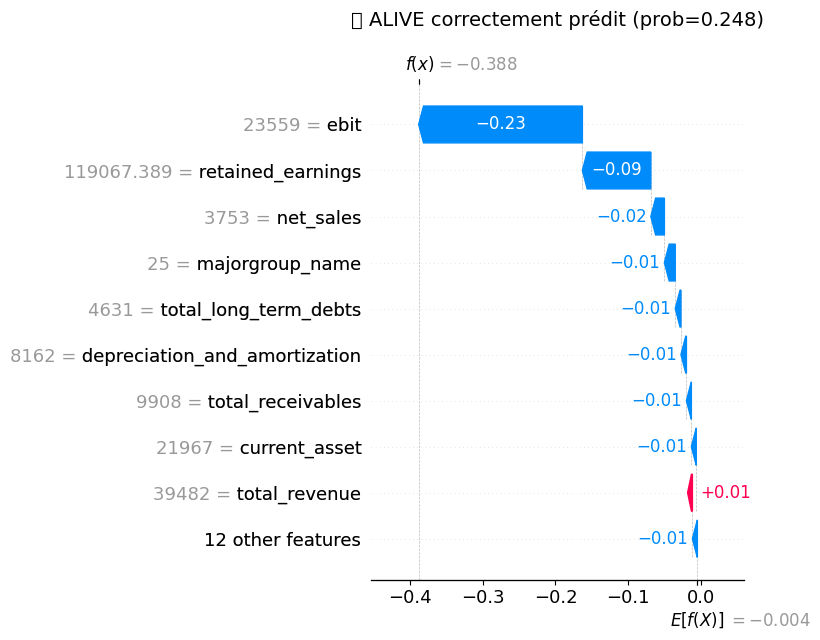


7. Analyse des erreurs...

❌ Faux positifs: 3 (3.0%)
❌ Faux négatifs: 0 (0.0%)

🔍 Exemple FAUX POSITIF (index 52):
   Prédit: FAILED | Réalité: ALIVE | Prob: 0.753


C:\Users\Thomas L\AppData\Local\Temp\ipykernel_14640\1117117074.py:315: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Thomas L\.venv311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


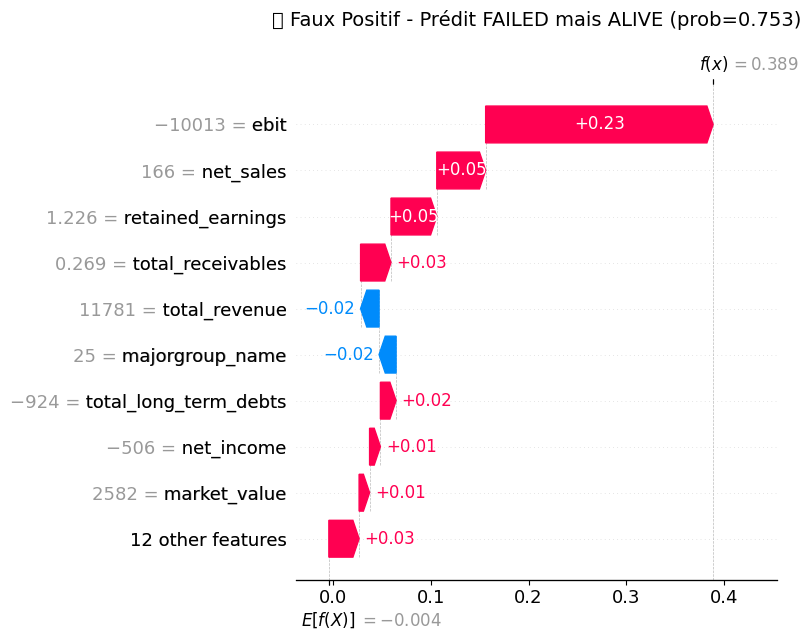


✅ ANALYSE SHAP TERMINÉE

💡 Insight: En retirant les colonnes redondantes,
   le modèle est plus simple et les importances SHAP
   sont plus claires et interprétables!


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# ============================================
# PARTIE 1: PRÉPARATION DES DONNÉES (NETTOYÉE)
# ============================================
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

y = df['status_label']
X = df.drop(columns=['company_name', 'status_label'])

# ⚠️ RETIRER LES COLONNES REDONDANTES
# On garde les versions textuelles (plus interprétables) et on retire les numériques
print("Colonnes avant nettoyage:", X.shape[1])
X = X.drop(columns=['majorgroup', 'division'])  # Retirer les versions numériques
print("Colonnes après nettoyage:", X.shape[1])
print("\nColonnes conservées:")
print(X.columns.tolist())

# Encodage des colonnes catégorielles restantes
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"\nColonnes catégorielles à encoder: {list(categorical_cols)}")

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    # Afficher le mapping pour les colonnes importantes
    if col in ['majorgroup_name', 'division_name']:
        print(f"\n📋 Mapping {col}:")
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        for k, v in list(mapping.items())[:5]:  # Afficher les 5 premiers
            print(f"  {k} -> {v}")
        print(f"  ... ({len(mapping)} catégories au total)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ============================================
# PARTIE 2: ENTRAÎNEMENT XGBOOST
# ============================================
print("\n" + "="*60)
print("ENTRAÎNEMENT XGBOOST")
print("="*60)

dtrain = xgb.DMatrix(X_train_res, label=y_train_res.map({'alive':0,'failed':1}))
dtest = xgb.DMatrix(X_test, label=y_test.map({'alive':0,'failed':1}))

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'auc',
    'scale_pos_weight': len(y_train_res[y_train_res=='alive']) / len(y_train_res[y_train_res=='failed']),
    'seed': 42
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Trouver le seuil optimal
y_proba = xgb_model.predict(dtest)
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_thresh = np.where(y_proba > t, 'failed', 'alive')
    f1_scores.append(f1_score(y_test.map({'alive':0,'failed':1}),
                               pd.Series(y_pred_thresh).map({'alive':0,'failed':1})))
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\n✓ Seuil optimal: {best_thresh:.2f}")

# Évaluation
y_pred = np.where(y_proba > best_thresh, 'failed', 'alive')
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\n📊 ROC AUC: {roc_auc_score(y_test.map({'alive':0,'failed':1}), y_proba):.4f}")

# Feature importance XGBoost native (pour comparaison)
print("\n📊 Top 10 Feature Importance (XGBoost native):")
importances_xgb = pd.Series(xgb_model.get_score(importance_type='weight'))

# Mapper les noms de features XGBoost aux noms de colonnes
def map_feature_name(xgb_name):
    """Convertit les noms XGBoost (f0, f1, ...) en noms de colonnes réels"""
    if xgb_name.startswith('f') and xgb_name[1:].isdigit():
        idx = int(xgb_name[1:])
        return X.columns[idx]
    return xgb_name

importances_xgb.index = [map_feature_name(col) for col in importances_xgb.index]
print(importances_xgb.sort_values(ascending=False).head(10))

# ============================================
# PARTIE 3: ANALYSE SHAP
# ============================================
print("\n" + "="*60)
print("ANALYSE SHAP (sans redondance)")
print("="*60)

explainer = shap.TreeExplainer(xgb_model)

print("\n⏳ Calcul des valeurs SHAP en cours...")
shap_values = explainer.shap_values(X_test)
print("✓ Valeurs SHAP calculées")

# ============================================
# 1. SUMMARY PLOT - Vue d'ensemble
# ============================================
print("\n1. Summary Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False, max_display=15)
plt.title("SHAP Summary Plot - Impact des features (SANS redondance)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# ============================================
# 2. BAR PLOT - Importance moyenne
# ============================================
print("2. Bar Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display=15)
plt.title("SHAP Feature Importance (SANS redondance)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# ============================================
# 3. COMPARAISON: XGBoost vs SHAP
# ============================================
print("\n3. Comparaison Feature Importance...")

# SHAP importance (mean absolute SHAP value)
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

# XGBoost importance
xgb_importance = pd.DataFrame({
    'feature': importances_xgb.index,
    'xgb_importance': importances_xgb.values
}).sort_values('xgb_importance', ascending=False)

# Merge et afficher
comparison = shap_importance.merge(xgb_importance, on='feature', how='outer').fillna(0)
comparison = comparison.sort_values('shap_importance', ascending=False).head(15)

print("\n📊 Comparaison XGBoost vs SHAP (Top 15):")
print(comparison.to_string(index=False))

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# XGBoost
xgb_top = comparison.nlargest(10, 'xgb_importance')
ax1.barh(xgb_top['feature'], xgb_top['xgb_importance'], color='steelblue')
ax1.set_xlabel('XGBoost Importance (weight)')
ax1.set_title('Top 10 Features - XGBoost Native')
ax1.invert_yaxis()

# SHAP
shap_top = comparison.nlargest(10, 'shap_importance')
ax2.barh(shap_top['feature'], shap_top['shap_importance'], color='coral')
ax2.set_xlabel('Mean |SHAP value|')
ax2.set_title('Top 10 Features - SHAP')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# ============================================
# 4. DEPENDENCE PLOTS - Features clés
# ============================================
print("\n4. Dependence Plots...")

# EBIT
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "ebit",
    shap_values,
    X_test,
    interaction_index="retained_earnings",
    show=False
)
plt.title("Impact de EBIT (coloré par retained_earnings)", fontsize=14)
plt.tight_layout()
plt.show()

# MajorGroup_name
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    "majorgroup_name",
    shap_values,
    X_test,
    interaction_index="division_name",
    show=False
)
plt.title("Impact de MajorGroup (coloré par division)", fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# 5. ANALYSE FAILED vs ALIVE
# ============================================
print("\n5. Analyse comparative Failed vs Alive...")

failed_idx = np.where(y_test == 'failed')[0]
alive_idx = np.where(y_test == 'alive')[0]

failed_shap_mean = np.abs(shap_values[failed_idx]).mean(axis=0)
alive_shap_mean = np.abs(shap_values[alive_idx]).mean(axis=0)

top_failed = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap_failed': failed_shap_mean
}).sort_values('mean_abs_shap_failed', ascending=False).head(10)

top_alive = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap_alive': alive_shap_mean
}).sort_values('mean_abs_shap_alive', ascending=False).head(10)

print("\n💥 Top 10 features pour FAILED:")
print(top_failed.to_string(index=False))

print("\n✅ Top 10 features pour ALIVE:")
print(top_alive.to_string(index=False))

# ============================================
# 6. WATERFALL - Exemples de prédictions
# ============================================
print("\n6. Waterfall Plots - Explications individuelles...")

# Exemple 1: Une entreprise FAILED correctement prédite
failed_correct = np.where((y_pred == 'failed') & (y_test == 'failed'))[0]
if len(failed_correct) > 0:
    idx = failed_correct[0]
    shap_exp = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_exp, show=False)
    plt.title(f"✅ FAILED correctement prédit (prob={y_proba[idx]:.3f})", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Exemple 2: Une entreprise ALIVE correctement prédite
alive_correct = np.where((y_pred == 'alive') & (y_test == 'alive'))[0]
if len(alive_correct) > 0:
    idx = alive_correct[0]
    shap_exp = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_exp, show=False)
    plt.title(f"✅ ALIVE correctement prédit (prob={y_proba[idx]:.3f})", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# ============================================
# 7. ANALYSE DES ERREURS
# ============================================
print("\n7. Analyse des erreurs...")

false_positives = np.where((y_pred == 'failed') & (y_test == 'alive'))[0]
false_negatives = np.where((y_pred == 'alive') & (y_test == 'failed'))[0]

print(f"\n❌ Faux positifs: {len(false_positives)} ({len(false_positives)/len(y_test)*100:.1f}%)")
print(f"❌ Faux négatifs: {len(false_negatives)} ({len(false_negatives)/len(y_test)*100:.1f}%)")

# Faux positif
if len(false_positives) > 0:
    fp_idx = false_positives[0]
    print(f"\n🔍 Exemple FAUX POSITIF (index {fp_idx}):")
    print(f"   Prédit: FAILED | Réalité: ALIVE | Prob: {y_proba[fp_idx]:.3f}")
    
    shap_exp_fp = shap.Explanation(
        values=shap_values[fp_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[fp_idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_exp_fp, show=False)
    plt.title(f"❌ Faux Positif - Prédit FAILED mais ALIVE (prob={y_proba[fp_idx]:.3f})", 
              fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# Faux négatif
if len(false_negatives) > 0:
    fn_idx = false_negatives[0]
    print(f"\n🔍 Exemple FAUX NÉGATIF (index {fn_idx}):")
    print(f"   Prédit: ALIVE | Réalité: FAILED | Prob: {y_proba[fn_idx]:.3f}")
    
    shap_exp_fn = shap.Explanation(
        values=shap_values[fn_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[fn_idx].values,
        feature_names=X_test.columns.tolist()
    )
    
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap_exp_fn, show=False)
    plt.title(f"❌ Faux Négatif - Prédit ALIVE mais FAILED (prob={y_proba[fn_idx]:.3f})", 
              fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("✅ ANALYSE SHAP TERMINÉE")
print("="*60)
print("\n💡 Insight: En retirant les colonnes redondantes,")
print("   le modèle est plus simple et les importances SHAP")
print("   sont plus claires et interprétables!")

C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4/4 - 2s - 567ms/step - AUC: 0.5928 - loss: 0.6761 - val_AUC: 0.6328 - val_loss: 0.7075
Epoch 2/100
4/4 - 0s - 42ms/step - AUC: 0.6540 - loss: 0.6538 - val_AUC: 0.7760 - val_loss: 0.6741
Epoch 3/100


C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


4/4 - 0s - 42ms/step - AUC: 0.7255 - loss: 0.6271 - val_AUC: 0.8099 - val_loss: 0.6412
Epoch 4/100
4/4 - 0s - 40ms/step - AUC: 0.8189 - loss: 0.6043 - val_AUC: 0.8411 - val_loss: 0.6165
Epoch 5/100
4/4 - 0s - 41ms/step - AUC: 0.8053 - loss: 0.5940 - val_AUC: 0.8490 - val_loss: 0.6022
Epoch 6/100
4/4 - 0s - 37ms/step - AUC: 0.8678 - loss: 0.5707 - val_AUC: 0.8320 - val_loss: 0.5777
Epoch 7/100
4/4 - 0s - 34ms/step - AUC: 0.8638 - loss: 0.5544 - val_AUC: 0.7878 - val_loss: 0.5416
Epoch 8/100
4/4 - 0s - 48ms/step - AUC: 0.8575 - loss: 0.5492 - val_AUC: 0.7799 - val_loss: 0.5017
Epoch 9/100
4/4 - 0s - 51ms/step - AUC: 0.8817 - loss: 0.5282 - val_AUC: 0.8294 - val_loss: 0.4679
Epoch 10/100
4/4 - 0s - 38ms/step - AUC: 0.8966 - loss: 0.5152 - val_AUC: 0.8958 - val_loss: 0.4517
Epoch 11/100
4/4 - 0s - 38ms/step - AUC: 0.9022 - loss: 0.4867 - val_AUC: 0.8958 - val_loss: 0.4391
Epoch 12/100
4/4 - 0s - 40ms/step - AUC: 0.8978 - loss: 0.4823 - val_AUC: 0.9076 - val_loss: 0.4316
Epoch 13/100
4/4 - 

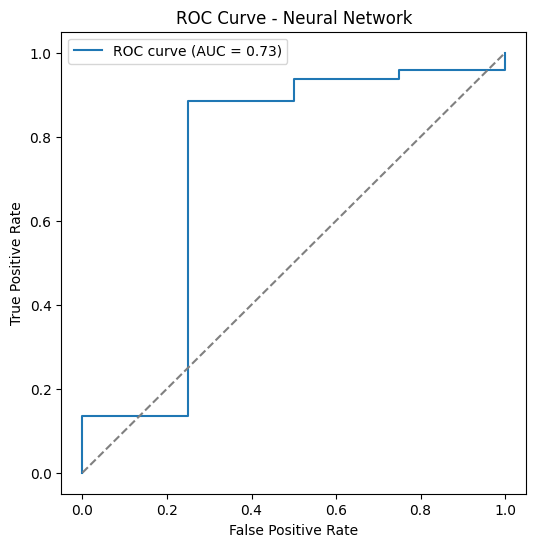

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Étape 1 : Chargement dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation features ---
y = df['status_label']
X = df.drop(columns=['company_name','status_label'])

# Encodage colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Normalisation des features numériques
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Étape 3 : Split train/test stratifié ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Étape 4 : Gestion du déséquilibre ---
# Option 1 : SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Étape 5 : Conversion labels en 0/1 ---
y_train_res_bin = y_train_res.map({'alive':0,'failed':1}).values
y_test_bin = y_test.map({'alive':0,'failed':1}).values

# --- Étape 6 : Construction du Neural Network ---
model = Sequential([
    Dense(128, input_dim=X_train_res.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

# Early stopping pour éviter overfitting
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

# --- Étape 7 : Entraînement ---
history = model.fit(
    X_train_res, y_train_res_bin,
    validation_data=(X_test, y_test_bin),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=2
)

# --- Étape 8 : Probabilités et seuil optimisé ---
y_proba = model.predict(X_test).flatten()
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)
    f1_scores.append(f1_score(y_test_bin, y_pred_thresh))
best_thresh = thresholds[np.argmax(f1_scores)]
print("Seuil optimal pour F1-score (failed) :", best_thresh)

y_pred = (y_proba > best_thresh).astype(int)

# --- Étape 9 : Évaluation finale ---
print("\nClassification Report :\n", classification_report(y_test_bin, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test_bin, y_pred))
print("ROC AUC :", roc_auc_score(y_test_bin, y_proba))

# --- Étape 10 : Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test_bin, y_proba):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.show()


Epoch 1/100


C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 - 2s - 532ms/step - AUC: 0.4148 - loss: 0.7133 - val_AUC: 0.8607 - val_loss: 0.7045
Epoch 2/100
4/4 - 0s - 38ms/step - AUC: 0.6068 - loss: 0.6773 - val_AUC: 0.9245 - val_loss: 0.6734
Epoch 3/100


C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


4/4 - 0s - 41ms/step - AUC: 0.6696 - loss: 0.6573 - val_AUC: 0.9414 - val_loss: 0.6418
Epoch 4/100
4/4 - 0s - 41ms/step - AUC: 0.7741 - loss: 0.6319 - val_AUC: 0.9492 - val_loss: 0.6085
Epoch 5/100
4/4 - 0s - 40ms/step - AUC: 0.8110 - loss: 0.6124 - val_AUC: 0.9518 - val_loss: 0.5877
Epoch 6/100
4/4 - 0s - 39ms/step - AUC: 0.8457 - loss: 0.5862 - val_AUC: 0.9648 - val_loss: 0.5794
Epoch 7/100
4/4 - 0s - 48ms/step - AUC: 0.8625 - loss: 0.5729 - val_AUC: 0.9583 - val_loss: 0.5699
Epoch 8/100
4/4 - 0s - 44ms/step - AUC: 0.8616 - loss: 0.5658 - val_AUC: 0.9557 - val_loss: 0.5690
Epoch 9/100
4/4 - 0s - 40ms/step - AUC: 0.8755 - loss: 0.5437 - val_AUC: 0.9505 - val_loss: 0.5651
Epoch 10/100
4/4 - 0s - 39ms/step - AUC: 0.8670 - loss: 0.5336 - val_AUC: 0.9479 - val_loss: 0.5598
Epoch 11/100
4/4 - 0s - 42ms/step - AUC: 0.8712 - loss: 0.5187 - val_AUC: 0.9505 - val_loss: 0.5365
Epoch 12/100
4/4 - 0s - 40ms/step - AUC: 0.8777 - loss: 0.5001 - val_AUC: 0.9557 - val_loss: 0.4911
Epoch 13/100
4/4 - 

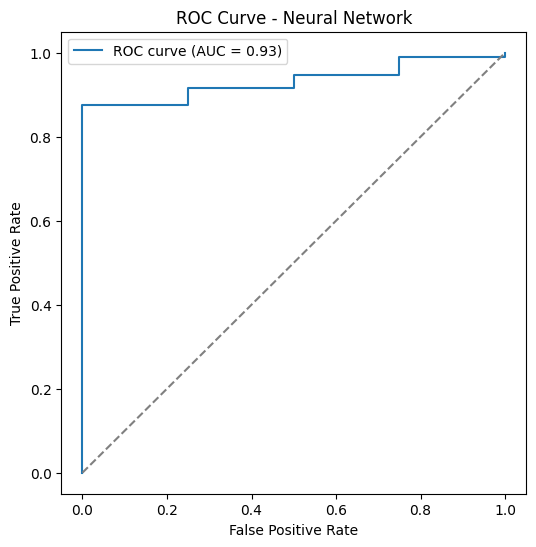

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Étape 1 : Chargement dataset enrichi ---
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# --- Étape 2 : Préparation features ---
y = df['status_label']
X = df.drop(columns=['company_name','status_label'])

# Encodage colonnes catégorielles
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Normalisation des features numériques
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Étape 3 : Split train/test stratifié ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Étape 4 : Gestion du déséquilibre ---
# Option 1 : SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Étape 5 : Conversion labels en 0/1 ---
y_train_res_bin = y_train_res.map({'alive':0,'failed':1}).values
y_test_bin = y_test.map({'alive':0,'failed':1}).values

# --- Étape 6 : Construction du Neural Network ---
model = Sequential([
    Dense(128, input_dim=X_train_res.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

# Early stopping pour éviter overfitting
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

# --- Étape 7 : Entraînement ---
history = model.fit(
    X_train_res, y_train_res_bin,
    validation_data=(X_test, y_test_bin),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=2
)

# --- Étape 8 : Probabilités et seuil optimisé ---
y_proba = model.predict(X_test).flatten()
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
for t in thresholds:
    y_pred_thresh = (y_proba > t).astype(int)
    f1_scores.append(f1_score(y_test_bin, y_pred_thresh))
best_thresh = thresholds[np.argmax(f1_scores)]
print("Seuil optimal pour F1-score (failed) :", best_thresh)

y_pred = (y_proba > best_thresh).astype(int)

# --- Étape 9 : Évaluation finale ---
print("\nClassification Report :\n", classification_report(y_test_bin, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test_bin, y_pred))
print("ROC AUC :", roc_auc_score(y_test_bin, y_proba))

# --- Étape 10 : Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test_bin, y_proba):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.show()


In [23]:
import numpy as np

In [24]:
y_train_bin = y_train_res
y_test_bin  = y_test

Vérification formes :
X_train_res : (770, 23)
y_train_bin : (770,)   →  mean = 0.5
y_test_bin  : (100,)   →  mean = 0.96
Poids des classes : {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/150


C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - AUC: 0.5309 - loss: 0.6993 - val_AUC: 0.9167 - val_loss: 0.6772
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.6713 - loss: 0.6745 - val_AUC: 0.8867 - val_loss: 0.6536


C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.7531 - loss: 0.6512 - val_AUC: 0.8698 - val_loss: 0.6214
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.7472 - loss: 0.6359 - val_AUC: 0.8646 - val_loss: 0.5919
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.7928 - loss: 0.6148 - val_AUC: 0.8672 - val_loss: 0.5664
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - AUC: 0.8280 - loss: 0.5960 - val_AUC: 0.8880 - val_loss: 0.5251
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.8328 - loss: 0.5739 - val_AUC: 0.8997 - val_loss: 0.5055
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.8494 - loss: 0.5558 - val_AUC: 0.8997 - val_loss: 0.4742
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.8697 - loss: 0.5192 - val_AUC: 0.9362 - val_loss: 0.4512
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.8631 - loss: 0.4980 - val_AUC: 0.9323 - val_loss: 0.4319
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - AUC: 0.8811 - loss

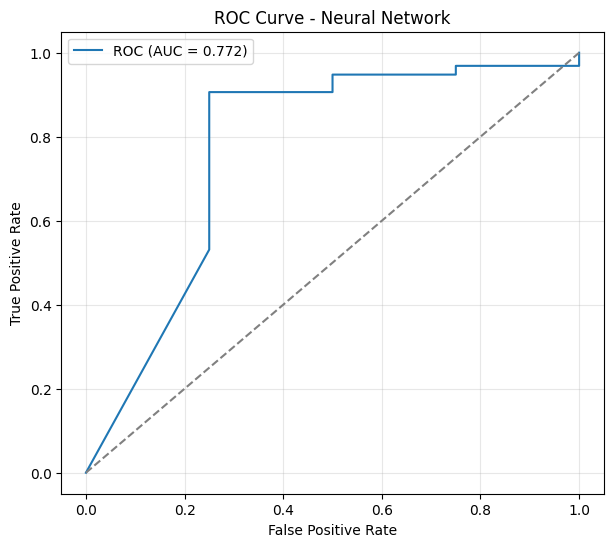

In [25]:
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────
# Conversion en labels binaires (0 = alive, 1 = failed)
# ────────────────────────────────────────────────────────────────
# Si tes labels sont encore 'alive' / 'failed' (chaînes)
y_train_bin = (y_train_res == 'failed').astype(int)     # ou .map({'alive':0, 'failed':1})
y_test_bin  = (y_test == 'failed').astype(int)

# Si tu avais déjà fait du SMOTE sur des labels numériques, tu peux aussi faire :
# y_train_bin = y_train_res.astype(int)   # si déjà 0/1

print("Vérification formes :")
print("X_train_res :", X_train_res.shape)
print("y_train_bin :", y_train_bin.shape, "  →  mean =", y_train_bin.mean().round(4))
print("y_test_bin  :", y_test_bin.shape,  "  →  mean =", y_test_bin.mean().round(4))

# ────────────────────────────────────────────────────────────────
# Calcul des poids de classes (balanced)
# ────────────────────────────────────────────────────────────────
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bin),
    y=y_train_bin
)

class_weights = dict(enumerate(weights))  # {0: poids_alive, 1: poids_failed}
print("Poids des classes :", class_weights)

# ────────────────────────────────────────────────────────────────
# Modèle Neural Network plus profond
# ────────────────────────────────────────────────────────────────
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC']
)

early_stop = EarlyStopping(
    monitor='val_auc',    # ou 'val_AUC' selon ta version keras
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# ────────────────────────────────────────────────────────────────
# Entraînement
# ────────────────────────────────────────────────────────────────
history = nn_model.fit(
    X_train_res, y_train_bin,
    validation_data=(X_test, y_test_bin),
    epochs=150,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1          # 1 ou 2 selon si tu veux voir la progression
)

# ────────────────────────────────────────────────────────────────
# Prédictions + optimisation du seuil (focus rappel failed)
# ────────────────────────────────────────────────────────────────
y_proba_nn = nn_model.predict(X_test, batch_size=256).flatten()

# Recherche du meilleur seuil (exemple avec F1, tu peux changer pour recall)
thresholds = np.arange(0.05, 0.95, 0.01)
f1_scores = [f1_score(y_test_bin, (y_proba_nn > t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"\nSeuil optimal pour F1-score : {best_thresh:.3f}")

y_pred_opt = (y_proba_nn > best_thresh).astype(int)

# ────────────────────────────────────────────────────────────────
# Évaluation finale
# ────────────────────────────────────────────────────────────────
print("\nClassification Report (seuil optimisé) :\n")
print(classification_report(y_test_bin, y_pred_opt, target_names=['alive', 'failed']))

print("\nConfusion Matrix :\n", confusion_matrix(y_test_bin, y_pred_opt))

print("\nROC AUC :", roc_auc_score(y_test_bin, y_proba_nn))

# ────────────────────────────────────────────────────────────────
# Courbe ROC
# ────────────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_nn)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc_score(y_test_bin, y_proba_nn):.3f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Epoch 1/150


C:\Users\Thomas L\.venv311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 - 3s - 749ms/step - AUC: 0.5387 - loss: 0.6931 - val_AUC: 0.8164 - val_loss: 0.6897
Epoch 2/150
4/4 - 0s - 50ms/step - AUC: 0.6376 - loss: 0.6659 - val_AUC: 0.8490 - val_loss: 0.6696
Epoch 3/150
4/4 - 0s - 49ms/step - AUC: 0.7244 - loss: 0.6443 - val_AUC: 0.8438 - val_loss: 0.6493
Epoch 4/150
4/4 - 0s - 42ms/step - AUC: 0.7546 - loss: 0.6282 - val_AUC: 0.8555 - val_loss: 0.6293
Epoch 5/150
4/4 - 0s - 48ms/step - AUC: 0.7820 - loss: 0.6120 - val_AUC: 0.8750 - val_loss: 0.6192
Epoch 6/150
4/4 - 0s - 42ms/step - AUC: 0.8078 - loss: 0.5837 - val_AUC: 0.8893 - val_loss: 0.5978
Epoch 7/150
4/4 - 0s - 43ms/step - AUC: 0.8449 - loss: 0.5627 - val_AUC: 0.8971 - val_loss: 0.5532
Epoch 8/150
4/4 - 0s - 46ms/step - AUC: 0.8389 - loss: 0.5384 - val_AUC: 0.9193 - val_loss: 0.4997
Epoch 9/150
4/4 - 0s - 45ms/step - AUC: 0.8597 - loss: 0.5102 - val_AUC: 0.9245 - val_loss: 0.4563
Epoch 10/150
4/4 - 0s - 42ms/step - AUC: 0.8745 - loss: 0.4852 - val_AUC: 0.9245 - val_loss: 0.4562
Epoch 11/150
4/4 - 0

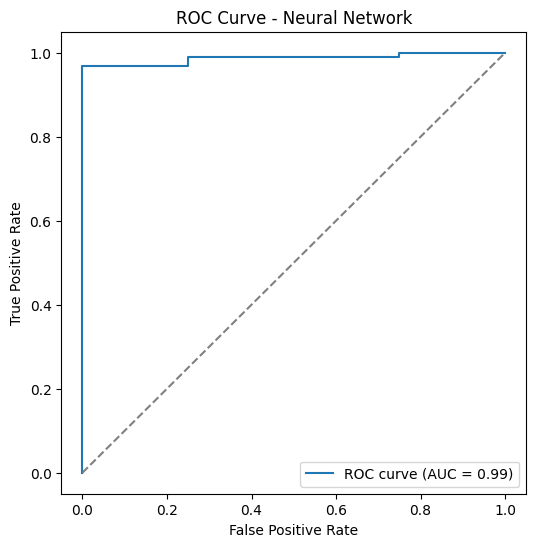

In [26]:
from sklearn.utils import class_weight

# --- Calcul des poids des classes ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_res_bin), y=y_train_res_bin)
class_weights = {0: weights[0], 1: weights[1]}

# --- Neural Network plus profond ---
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_res.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

early_stop = EarlyStopping(monitor='val_AUC', mode='max', patience=15, restore_best_weights=True)

# --- Entraînement ---
history = nn_model.fit(
    X_train_res, y_train_res_bin,
    validation_data=(X_test, y_test_bin),
    epochs=150, batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2
)

# --- Probabilités et seuil optimisé pour rappel ---
y_proba_nn = nn_model.predict(X_test).flatten()
thresholds = np.arange(0.05, 0.9, 0.01)
recall_scores = [f1_score(y_test_bin, (y_proba_nn>t).astype(int), average='binary') for t in thresholds]  # f1 ou recall selon stratégie
best_thresh = thresholds[np.argmax(recall_scores)]
y_pred = (y_proba_nn > best_thresh).astype(int)
print("Seuil optimal pour rappel (failed) :", best_thresh)

# --- Évaluation finale ---
print("\nClassification Report :\n", classification_report(y_test_bin, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test_bin, y_pred))
print("ROC AUC :", roc_auc_score(y_test_bin, y_proba_nn))

# --- Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_nn)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test_bin, y_proba_nn):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.show()


In [27]:
from imblearn.over_sampling import BorderlineSMOTE, ADASYN

smote = BorderlineSMOTE(random_state=42)
# ou
smote = ADASYN(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


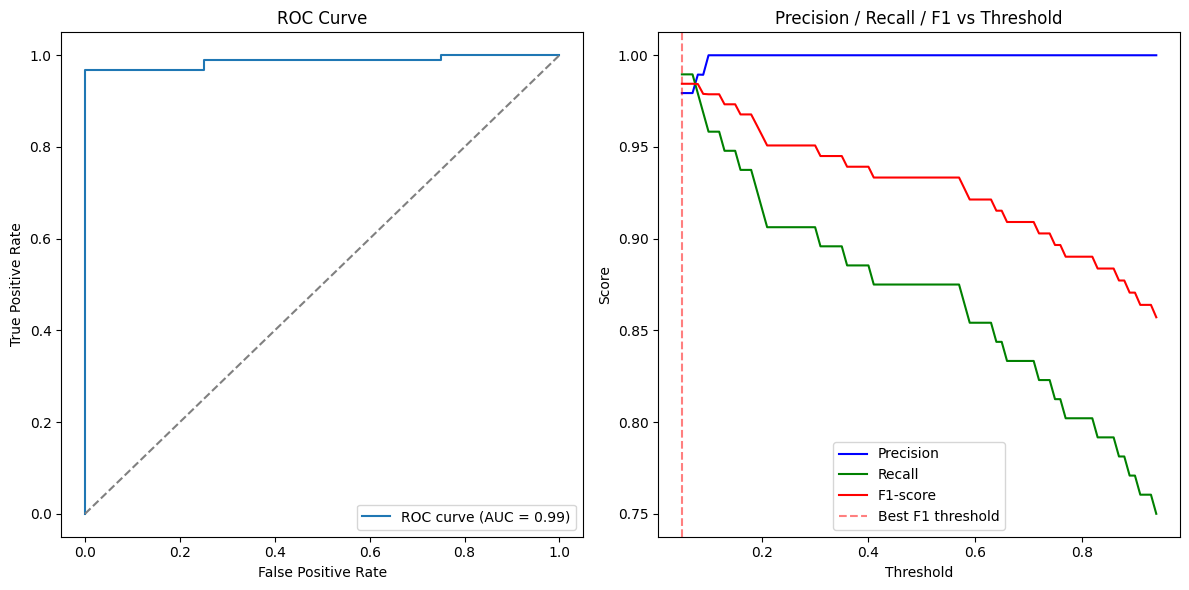

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

# Probabilités déjà calculées
y_scores = y_proba_nn  # output du NN
y_true = y_test_bin

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# --- Precision / Recall / F1 vs seuil ---
thresholds = np.arange(0.05, 0.95, 0.01)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_thresh = (y_scores > t).astype(int)
    precisions.append(precision_score(y_true, y_pred_thresh))
    recalls.append(recall_score(y_true, y_pred_thresh))
    f1s.append(f1_score(y_true, y_pred_thresh))

# --- Plot ---
plt.figure(figsize=(12,6))

# ROC
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision / Recall / F1 vs seuil
plt.subplot(1,2,2)
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1s, label='F1-score', color='red')
plt.axvline(x=thresholds[np.argmax(f1s)], color='red', linestyle='--', alpha=0.5, label="Best F1 threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# y_pred déjà calculé avec le seuil choisi
# y_test_bin = labels réels de test
# y_proba_nn = probabilités prédites par le NN

print("\nClassification Report :\n", classification_report(y_test_bin, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test_bin, y_pred))
print("ROC AUC :", roc_auc_score(y_test_bin, y_proba_nn))


Classification Report :
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.98      0.99      0.98        96

    accuracy                           0.97       100
   macro avg       0.82      0.74      0.78       100
weighted avg       0.97      0.97      0.97       100

Confusion Matrix :
 [[ 2  2]
 [ 1 95]]
ROC AUC : 0.9869791666666667


In [30]:
y_train_bin = (y_train == 1).astype(int)
y_test_bin  = (y_test == 1).astype(int)

In [31]:
print(y_train.head())       # affiche les premières valeurs
print(np.unique(y_train, return_counts=True))  # vérifie les classes présentes

129    failed
103    failed
89     failed
396    failed
315    failed
Name: status_label, dtype: object
(array(['alive', 'failed'], dtype=object), array([ 15, 385]))


In [32]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [33]:
# Si y_train et y_test contiennent des strings, convertir en binaire
# Exemple : 'failed' = 1, autre = 0
y_train_bin = (y_train == 'failed').astype(int)
y_test_bin  = (y_test == 'failed').astype(int)

# Vérification
print(np.unique(y_train_bin, return_counts=True))
print(np.unique(y_test_bin, return_counts=True))

(array([0, 1]), array([ 15, 385]))
(array([0, 1]), array([ 4, 96]))


In [34]:
from tensorflow.keras import Input

nn_model = Sequential([
    Input(shape=(X_train_res.shape[1],)),  # <-- input layer propre
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

Répartition des classes y_train : (array([0, 1]), array([ 15, 385]))
Répartition des classes y_test  : (array([0, 1]), array([ 4, 96]))
Epoch 1/150
3/3 - 3s - 913ms/step - AUC: 0.5589 - loss: 0.7398 - val_AUC: 0.4570 - val_loss: 0.6594
Epoch 2/150
3/3 - 0s - 62ms/step - AUC: 0.6560 - loss: 0.6810 - val_AUC: 0.6523 - val_loss: 0.6775
Epoch 3/150
3/3 - 0s - 59ms/step - AUC: 0.7095 - loss: 0.6651 - val_AUC: 0.7122 - val_loss: 0.6727
Epoch 4/150
3/3 - 0s - 56ms/step - AUC: 0.7509 - loss: 0.6512 - val_AUC: 0.7344 - val_loss: 0.6480
Epoch 5/150
3/3 - 0s - 55ms/step - AUC: 0.7563 - loss: 0.6398 - val_AUC: 0.7604 - val_loss: 0.6088
Epoch 6/150
3/3 - 0s - 58ms/step - AUC: 0.7900 - loss: 0.6149 - val_AUC: 0.7852 - val_loss: 0.5533
Epoch 7/150
3/3 - 0s - 68ms/step - AUC: 0.7680 - loss: 0.6001 - val_AUC: 0.8346 - val_loss: 0.4974
Epoch 8/150
3/3 - 0s - 60ms/step - AUC: 0.8352 - loss: 0.5531 - val_AUC: 0.8750 - val_loss: 0.4531
Epoch 9/150
3/3 - 0s - 56ms/step - AUC: 0.8242 - loss: 0.5374 - val_AUC

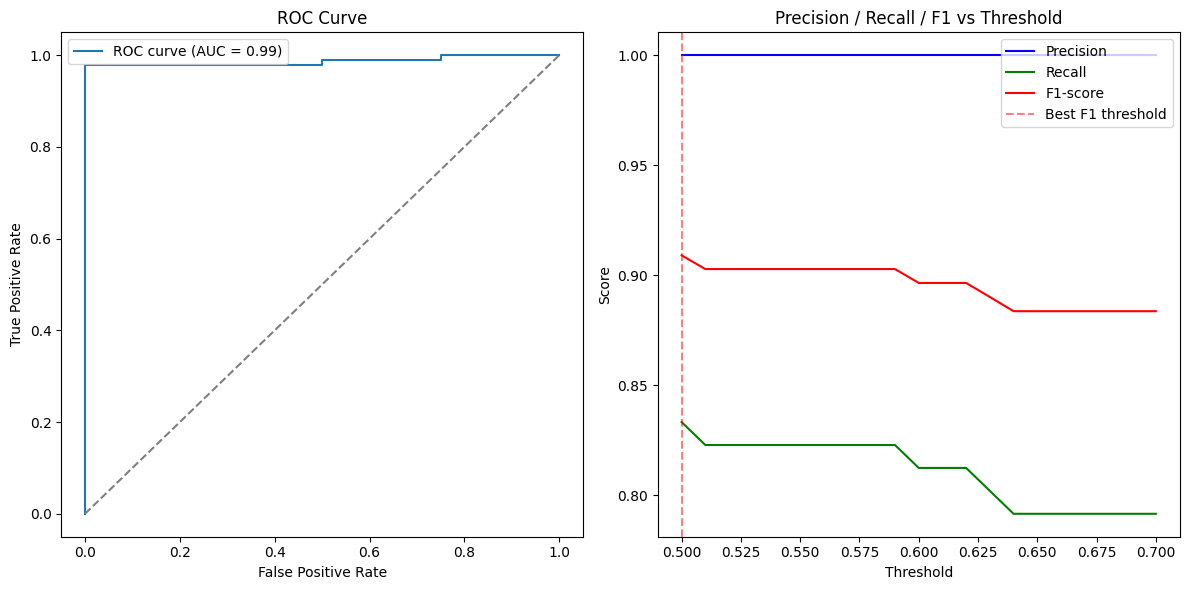

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import ADASYN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- Étape 0 : conversion des données ---
# Assure que les features sont numériques
X_train = X_train.astype(float)
X_test  = X_test.astype(float)

# Labels binaires : 'failed' = 1, autre = 0
y_train_bin = (y_train == 'failed').astype(int)
y_test_bin  = (y_test == 'failed').astype(int)

print("Répartition des classes y_train :", np.unique(y_train_bin, return_counts=True))
print("Répartition des classes y_test  :", np.unique(y_test_bin, return_counts=True))

# --- Sur-échantillonnage minoritaire ---
adasyn = ADASYN(sampling_strategy=0.5, n_neighbors=5, random_state=42)
X_train_res, y_train_res_bin = adasyn.fit_resample(X_train, y_train_bin)

# --- Calcul des poids des classes ---
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_res_bin), y=y_train_res_bin)
class_weights = {0: weights[0], 1: weights[1]}

# --- Neural Network profond ---
nn_model = Sequential([
    Input(shape=(X_train_res.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

early_stop = EarlyStopping(monitor='val_AUC', mode='max', patience=15, restore_best_weights=True)

# --- Entraînement ---
history = nn_model.fit(
    X_train_res, y_train_res_bin,
    validation_data=(X_test, y_test_bin),
    epochs=150, batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2
)

# --- Probabilités et seuil agressif pour boost recall ---
y_proba_nn = nn_model.predict(X_test).flatten()

thresholds = np.arange(0.5, 0.71, 0.01)  # plage 0.5-0.7
f1_scores = [f1_score(y_test_bin, (y_proba_nn > t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
y_pred = (y_proba_nn > best_thresh).astype(int)

print("Seuil optimal (F1-score) :", best_thresh)
print("\nClassification Report :\n", classification_report(y_test_bin, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test_bin, y_pred))
print("ROC AUC :", roc_auc_score(y_test_bin, y_proba_nn))

# --- Courbes ---
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_nn)
plt.figure(figsize=(12,6))

# ROC
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test_bin, y_proba_nn):.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision / Recall / F1 vs seuil
precisions, recalls, f1s = [], [], []
for t in thresholds:
    y_thresh = (y_proba_nn > t).astype(int)
    precisions.append(precision_score(y_test_bin, y_thresh))
    recalls.append(recall_score(y_test_bin, y_thresh))
    f1s.append(f1_score(y_test_bin, y_thresh))

plt.subplot(1,2,2)
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1s, label='F1-score', color='red')
plt.axvline(x=best_thresh, color='red', linestyle='--', alpha=0.5, label="Best F1 threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()


Imports terminés

=== Chargement des données ===
Shape après suppression lignes sans cible : (500, 25)

Répartition cible :
target
1    96.2
0     3.8
Name: proportion, dtype: float64

Colonnes restantes : ['current_asset', 'costs_of_good_sold', 'depreciation_and_amortization', 'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value', 'net_sales', 'total_assets', 'total_long_term_debts', 'ebit', 'gross_profit', 'total_current_liabilities', 'retained_earnings', 'total_revenue', 'total_liabilities', 'total_operating_expenses', 'target']

=== Conversion forcée des colonnes numériques ===
NaN par colonne après conversion :
current_asset                    0
costs_of_good_sold               0
depreciation_and_amortization    0
ebitda                           0
inventory                        0
net_income                       0
total_receivables                0
market_value                     0
net_sales                        0
total_assets                     0
total_l

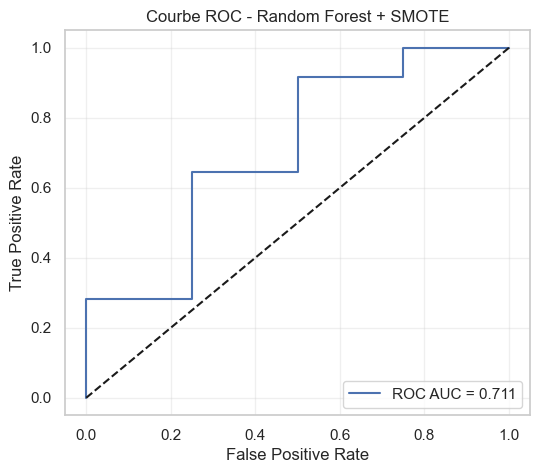


=== Recherche meilleur seuil (F1-score) ===
Meilleur seuil (F1) : 0.511
F1-score max : 0.985

Avec seuil optimisé F1 :
              precision    recall  f1-score   support

           0      1.000     0.250     0.400         4
           1      0.970     1.000     0.985        96

    accuracy                          0.970       100
   macro avg      0.985     0.625     0.692       100
weighted avg      0.971     0.970     0.961       100



In [36]:
# =============================================================================
# Notebook : Prédiction de faillite d'entreprises (US Bankruptcy)
# =============================================================================

# 1. Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 40)
sns.set(style="whitegrid")

print("Imports terminés\n")

# =============================================================================
# 2. Chargement et nettoyage initial
# =============================================================================

print("=== Chargement des données ===")
df = pd.read_csv("american_bankruptcy_dataset_enriched_sample.csv")

# Suppression des lignes où la cible est manquante
df = df[df["status_label"].notna()].copy().reset_index(drop=True)

print("Shape après suppression lignes sans cible :", df.shape)

# Création de la vraie cible binaire
df["target"] = df["status_label"].map({"alive": 0, "failed": 1}).astype(int)

print("\nRépartition cible :")
print(df["target"].value_counts(normalize=True).round(4) * 100)

# Colonnes à supprimer (identifiants + redondants / inutiles ici)
cols_to_drop = [
    "company_name", "status_label", "fyear",
    "division", "majorgroup", "division_name", "majorgroup_name"
]

df = df.drop(columns=cols_to_drop, errors="ignore")

print("\nColonnes restantes :", df.columns.tolist())

# =============================================================================
# 3. Correction des types numériques (virgule/point + chaînes parasites)
# =============================================================================

print("\n=== Conversion forcée des colonnes numériques ===")

numeric_cols = [
    'current_asset', 'costs_of_good_sold', 'depreciation_and_amortization',
    'ebitda', 'inventory', 'net_income', 'total_receivables', 'market_value',
    'net_sales', 'total_assets', 'total_long_term_debts', 'ebit', 'gross_profit',
    'total_current_liabilities', 'retained_earnings', 'total_revenue',
    'total_liabilities', 'total_operating_expenses'
]

for col in numeric_cols:
    if col in df.columns:
        # Remplacement virgule → point + conversion
        df[col] = df[col].astype(str).str.replace(",", ".").replace("", np.nan)
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("NaN par colonne après conversion :")
print(df[numeric_cols].isna().sum())

# Imputation très simple (médiane)
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

print("\nNaN restants après imputation médiane :", df.isna().sum().sum())

# =============================================================================
# 4. Features & cible
# =============================================================================

target = "target"
features = [c for c in df.columns if c != target]

X = df[features].copy()
y = df[target].copy()

print("\nX shape :", X.shape)
print("y shape :", y.shape)

# =============================================================================
# 5. Pipeline complet (préprocessing + modèle + sur-échantillonnage)
# =============================================================================

print("\n=== Définition du pipeline ===")

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("Features numériques :", len(numeric_features))
print("Features catégorielles :", categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), categorical_features)
    ],
    remainder="drop"
)

model_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42, sampling_strategy=0.4)),   # on ne va pas trop loin (0.4 = 40% minoritaire)
    ("classifier", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

# =============================================================================
# 6. Entraînement & évaluation
# =============================================================================

print("\n=== Split & Entraînement ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"Train : {X_train.shape}   |   Test : {X_test.shape}")
print(f"Proportion failed (train) : {y_train.mean():.2%}")

model_pipeline.fit(X_train, y_train)

# Prédictions
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Métriques
print("\n=== Rapport de classification ===\n")
print(classification_report(y_test, y_pred, digits=3))

print("ROC AUC :", round(roc_auc_score(y_test, y_proba), 4))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix :\n", cm)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Random Forest + SMOTE")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# =============================================================================
# 7. Seuil de décision optimisé (optionnel – maximiser F1 ou recall)
# =============================================================================

print("\n=== Recherche meilleur seuil (F1-score) ===")

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Meilleur seuil (F1) : {best_threshold:.3f}")
print(f"F1-score max : {f1_scores[best_idx]:.3f}")

# Prédiction avec seuil personnalisé
y_pred_custom = (y_proba >= best_threshold).astype(int)

print("\nAvec seuil optimisé F1 :")
print(classification_report(y_test, y_pred_custom, digits=3))